In [395]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns

## Configuraciones

In [396]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib


pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Configuraciones plot

In [397]:
TAM_TITULO = 35
TAM_ETIQUETA = 30

### Configuraciones de librerias

### Funciones auxiliares

In [398]:
font_size = 18

def crear_radares_alineados(df, fil, col, paleta_colores):
    
    # Categorias
    columnas = df.columns
    categorias = list(columnas[1:])
    N = len(categorias)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angulos = [n / float(N) * 2 * pi for n in range(N)]
    angulos += angulos[:1]
    
    # Color
    paleta = plt.cm.get_cmap(paleta_colores, len(df.index))
    
    lista = []
    
    for fila in range(0, len(df.index)):
        color = paleta(fila)
        
        # Initialise the spider plot
        ax = plt.subplot(3 , 2, fila + 1, polar=True, )
    
        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
    
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angulos[:-1], categorias, color='grey', size=10)
    
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([1,2,3,4], ["1","2","3","4"], color="grey", size=10)
        plt.ylim(0,4)
        
        # Ind1
        values=df.loc[fila].drop("provincia").values.flatten().tolist()
        values += values[:1]
        ax.plot(angulos, values, color=color, linewidth=1, linestyle='solid')
        ax.fill(angulos, values, color=color, alpha=0.4)
        
        plt.title(df["provincia"][fila], size=16, color=color, y=1.05)
        
        lista.append(ax)
    
    fig, lista = plt.subplots(0)
    #fig.subplots_adjust(left=None, bottom=100, right=None, top=150, wspace=None, hspace=None)



def crear_mapa(series, caracteristica,vmin, vmax, titulo, color):
    #Creo mi mapa de mexico
    mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

    #Le pongo los tildes al archivo de estados para que me coincidan con las provincias
    mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

    #Hago un nuevo dataframe con la información del mapa y la antiguedad para cada provincia
    gdf = mexico.set_index("ADMIN_NAME").join(series)
    
    #Grafico el mapa

    #Base donde se va a dibujar
    fig, base = plt.subplots(1, figsize=(10, 6))

    #Saco los ejes de lat y lng ya que no aportan al gráfico
    base.axis("off")

    #Pido que me coloreé en base a la antiguedad
    gdf.plot(column=caracteristica, cmap=color, linewidth=0.8, ax=base, edgecolor="0.8")

    #Setteo el título al gráfico
    base.set_title(titulo, fontsize = font_size)
    
    #Agrego la barra que indica la antiguedad
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm)

In [399]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

In [400]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

## Cantidad de NAN en campos a analizar

### Cantidad de NAN en provincia:

In [401]:
n_provincia_nan = df["provincia"].isnull().sum()
n_provincia_nan

155

### Cantidad de NAN en precio:

In [402]:
n_tipodepropiedad_nan = df["tipodepropiedad"].isnull().sum()
n_tipodepropiedad_nan

46

## ¿Cuáles son las provincias con propiedades más caras y cuáles con las más baratas?

In [403]:
provincia_precio = df.groupby('provincia')['precio'].mean()

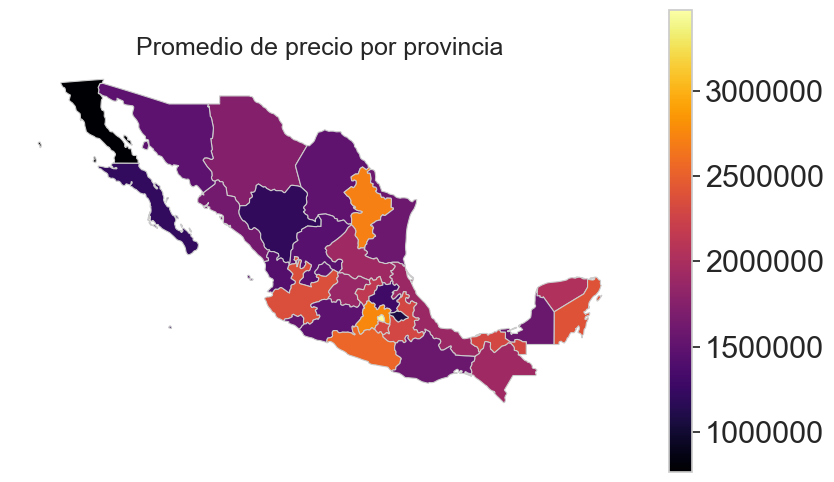

In [404]:
crear_mapa(provincia_precio, "precio", 767441, 3471705, "Promedio de precio por provincia", "inferno")

### Top 5 provincias con viviendas más caras

In [405]:
provincia_precio_df = provincia_precio.to_frame()
provincia_precio_df.rename(columns = {'precio': 'Precio promedio de propiedad'}, inplace=True)

In [406]:
provincias_caras = provincia_precio_df.nlargest(5, "Precio promedio de propiedad")
provincias_caras

,Precio promedio de propiedad
provincia,
Distrito Federal,"3,471,705.00"
Edo. de México,"2,762,465.00"
Nuevo León,"2,717,757.75"
Guerrero,"2,548,741.75"
Quintana Roo,"2,402,967.00"


### Top 5 estados con viviendas más baratas

In [407]:
provincias_baratas = provincia_precio_df.nsmallest(5, "Precio promedio de propiedad")
provincias_baratas

,Precio promedio de propiedad
provincia,
Baja California Norte,"767,441.75"
Tlaxcala,"1,080,993.38"
Durango,"1,210,389.00"
Baja California Sur,"1,216,452.88"
Hidalgo,"1,305,550.50"


## Promedios de las características de las propiedades por provincia

In [408]:
categorias = ["habitaciones", "banos", "piscina", "garages", "gimnasio", "usosmultiples"]

### Promedios de las caracteristicas de las provincias con propiedades más caras:

In [409]:
provincias_caras_df = df[df["provincia"].isin(list(provincias_caras.index))]
provincias_caras_df = provincias_caras_df.groupby("provincia")[categorias].mean()
provincias_caras_df

,habitaciones,banos,piscina,garages,gimnasio,usosmultiples
provincia,,,,,,
Distrito Federal,2.74,1.99,0.04,1.42,0.08,0.07
Edo. de México,2.97,2.08,0.06,1.66,0.07,0.07
Guerrero,2.82,2.29,0.56,1.33,0.17,0.14
Nuevo León,2.94,2.31,0.05,1.53,0.06,0.03
Quintana Roo,2.85,2.34,0.35,1.58,0.11,0.07


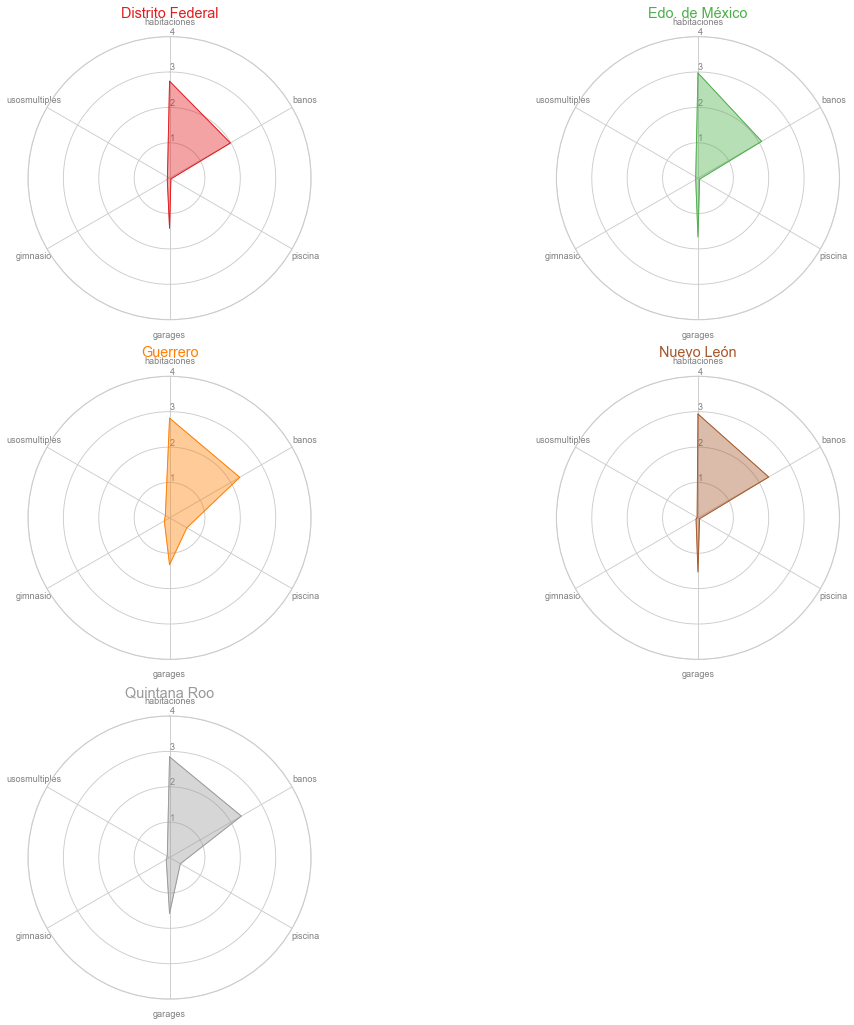

<Figure size 640x480 with 0 Axes>

In [410]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
 
crear_radares_alineados(provincias_caras_df.reset_index(), 3, 2, "Set1")

### Promedios de las caracteristicas de las provincias con propiedades más baratas:

In [412]:
provincias_baratas_df = df[df["provincia"].isin(list(provincias_baratas.index))]
provincias_baratas_df = provincias_baratas_df.groupby("provincia")[categorias].mean()
provincias_baratas_df

,habitaciones,banos,piscina,garages,gimnasio,usosmultiples
provincia,,,,,,
Baja California Norte,2.58,1.37,0.02,1.61,0.01,0.01
Baja California Sur,2.63,1.61,0.04,1.68,0.01,0.00
Durango,3.05,1.95,0.01,1.47,0.04,0.01
Hidalgo,2.88,1.81,0.03,1.48,0.05,0.05
Tlaxcala,2.83,1.55,0.00,1.38,0.05,0.00


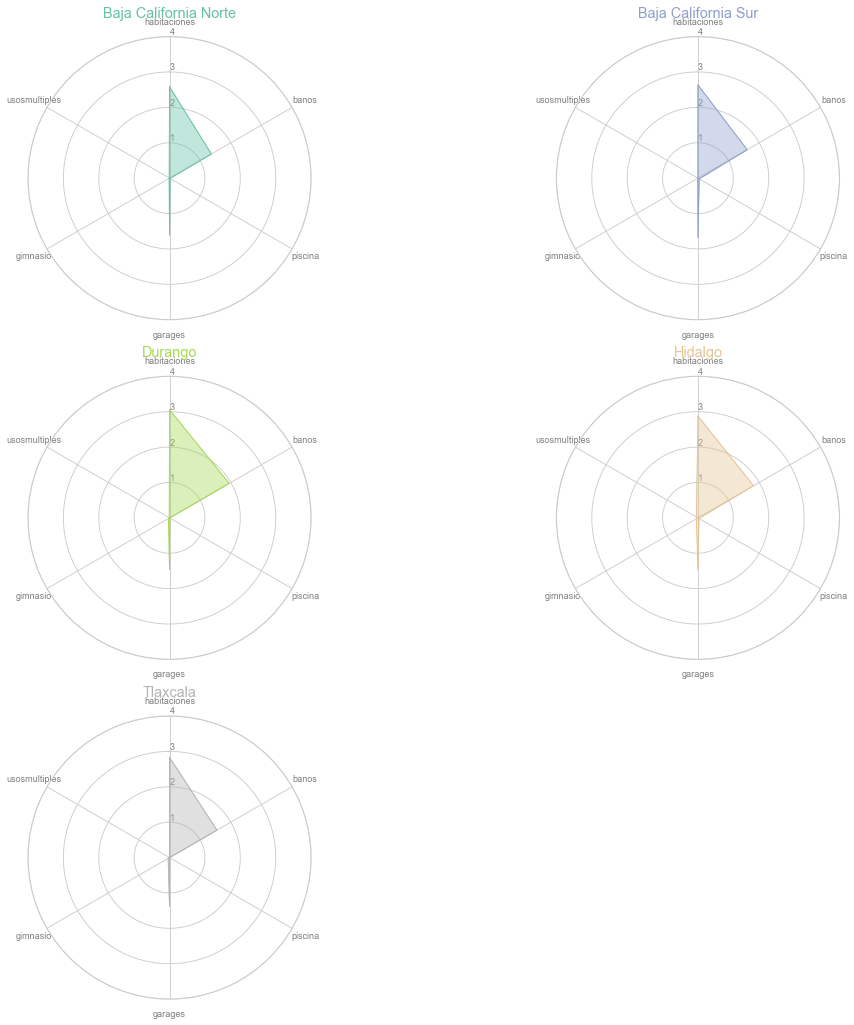

<Figure size 640x480 with 0 Axes>

In [413]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
 
crear_radares_alineados(provincias_baratas_df.reset_index(), 3, 2, "Set2")